In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

from sklearn.model_selection import train_test_split
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import np_utils
import keras.backend as K

import cv2
import scipy

from random import randint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [3]:
SEED = 42


In [5]:
data = pd.read_csv('data/fashion-mnist_train.csv', sep = ',')

In [6]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X,y = data.drop(['label'], axis = 1), data['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)


5    4859
8    4851
1    4826
4    4815
2    4800
9    4790
7    4776
0    4768
3    4758
6    4757
Name: label, dtype: int64

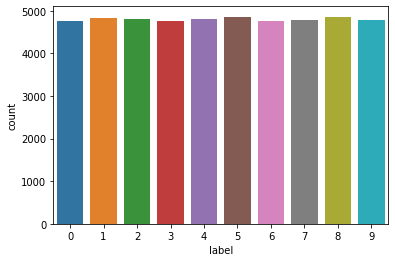

In [9]:
g = sns.countplot(y_train)

y_train.value_counts()

In [10]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
X_train = X_train / 255.
X_test = X_test / 255.

In [12]:
label_dictionnary = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 
                     3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 
                     7:'Sneaker', 8:'Bag', 9:'Ankle boot' }


In [13]:
def true_label(x):
    return label_dictionnary[x]

this represent a : Ankle boot


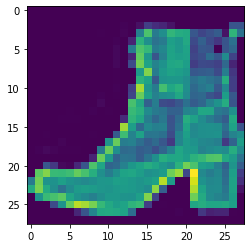

In [14]:
example = 16
g = plt.imshow(X_train.values.reshape(-1,28,28,1)[example][:,:,0])
print('this represent a : ' + true_label(y_train[example]))

# PCA

Dimension reduction to summarize information from data into fewer dimensions.

In [15]:
# Taking only the first N rows to speed things up
X_PCA = X_train[:3000].values

In [16]:
# Call the PCA method with 5 components. 
pca = PCA(n_components=5)
pca.fit(X_PCA)
X_5d = pca.transform(X_PCA)

In [17]:
# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target_name = y_train[:3000].apply(true_label)
Target = y_train[:3000]

In [18]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    mode = 'markers',
    text = Target_name,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]


In [19]:
layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

In [20]:
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

# t-SNE

In [21]:
# Invoking the t-SNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_PCA) 

In [22]:
traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    text = Target_name,
    mode = 'markers',
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

In [23]:
layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [24]:
y_predicted = [randint(0, 9) for p in range(0, len(y_test))]

In [25]:
print(accuracy_score(y_test,y_predicted))


0.10616666666666667


In [26]:
kfold = KFold(n_splits=3, shuffle=True)

X_train = X_train.reset_index(drop=True)

y_train.index = X_train.index
performance_accuracy = []

fold_count = 1

pipe = Pipeline([('pca',PCA(n_components=100)),
                 ('svm',RandomForestClassifier(n_jobs=-1, n_estimators=20))])

In [27]:
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    pipe.fit(X_kfold_train, y_kfold_train)
    y_kfold_pred = pipe.predict(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))


fold 1: 
-- training --
-- train ok ! --
fold 2: 
-- training --
-- train ok ! --
fold 3: 
-- training --
-- train ok ! --
0.8438958333333334


In [28]:
print(performance_accuracy)


[0.83975, 0.8490625, 0.842875]


In [29]:
pipe.fit(X_train, y_train)
y_predicted = pipe.predict(X_test)

print(accuracy_score(y_test, y_predicted))

0.84825


In [30]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [31]:
batch_size = 128
epochs = 30

In [32]:
def first_nn():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

In [33]:
model = first_nn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [35]:
fold_count = 1
performance_accuracy = []

for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    first_nn_crossval = first_nn()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer=RMSprop(),
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=10,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))


fold 1: 
-- training --
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
-- train ok ! --
fold 2: 
-- training --
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 2

In [36]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
375/375 [==============================] - 4s 10ms/step - loss: 0.5970 - accuracy: 0.7824
Epoch 2/30
375/375 [==============================] - 4s 10ms/step - loss: 0.4225 - accuracy: 0.8456
Epoch 3/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3802 - accuracy: 0.8626
Epoch 4/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3597 - accuracy: 0.8695
Epoch 5/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3456 - accuracy: 0.8759
Epoch 6/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3327 - accuracy: 0.8792
Epoch 7/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3241 - accuracy: 0.8834
Epoch 8/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3162 - accuracy: 0.8863
Epoch 9/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3081 - accuracy: 0.8895
Epoch 10/30
375/375 [==============================] - 4s 11ms/step - loss: 0.3025 - accura

In [37]:
y_pred_nn = model.predict_classes(X_test)


In [38]:
perf = accuracy_score(y_test, y_pred_nn)


In [39]:
print(perf)


0.8881666666666667


# CNN

In [40]:
img_rows, img_cols = 28, 28
batch_size = 256
epochs = 15
input_shape = (img_rows, img_cols, 1)

In [41]:
def first_cnn(input_shape=input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [42]:
model = first_cnn()
model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [43]:
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)             

In [44]:
x_train = np.array(X_train).reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = np.array(X_test).reshape(X_test.shape[0], img_rows, img_cols, 1)

In [45]:
fold_count = 1
performance_accuracy = []
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    X_kfold_train = np.array(X_kfold_train).reshape(X_kfold_train.shape[0], img_rows, img_cols, 1)
    X_kfold_test = np.array(X_kfold_test).reshape(X_kfold_test.shape[0], img_rows, img_cols, 1)
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    
    first_nn_crossval = first_cnn()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer=Adadelta(),
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=10,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))

fold 1: 
-- training --
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
fold 2: 
-- training --
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
fold 3: 
-- training --
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
-- train ok ! --
0.7845833333333333


In [46]:
model.fit(x_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, Y_test))

Epoch 1/15
188/188 [==============================] - 80s 427ms/step - loss: 3.0268 - accuracy: 0.1775 - val_loss: 2.5415 - val_accuracy: 0.1628
Epoch 2/15
188/188 [==============================] - 81s 430ms/step - loss: 2.1073 - accuracy: 0.3552 - val_loss: 1.8598 - val_accuracy: 0.3468
Epoch 3/15
188/188 [==============================] - 81s 432ms/step - loss: 1.6519 - accuracy: 0.4766 - val_loss: 1.0803 - val_accuracy: 0.6765
Epoch 4/15
188/188 [==============================] - 82s 437ms/step - loss: 1.3965 - accuracy: 0.5524 - val_loss: 0.8333 - val_accuracy: 0.7211
Epoch 5/15
188/188 [==============================] - 83s 441ms/step - loss: 1.2578 - accuracy: 0.5994 - val_loss: 0.7540 - val_accuracy: 0.7388
Epoch 6/15
188/188 [==============================] - 81s 432ms/step - loss: 1.1452 - accuracy: 0.6322 - val_loss: 0.7078 - val_accuracy: 0.7523
Epoch 7/15
188/188 [==============================] - 81s 433ms/step - loss: 1.0744 - accuracy: 0.6550 - val_loss: 0.6753 - val_ac

In [47]:
score = model.evaluate(x_test, Y_test, verbose=0)
y_pred_cnn = model.predict_classes(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5362861156463623
Test accuracy: 0.8103333115577698


# Pretrained Model


In [53]:
from PIL import Image
from skimage.transform import resize


In [48]:
batch_size = 256
epochs = 5

In [54]:
def resize_all(x, shape = (48,48)):
    band_shape = x.shape
    x_resize = np.zeros(shape = (band_shape[0],shape[0],shape[1]))
    for i in range(band_shape[0]):
        x_resize[i] = resize(x[i],shape)
    return x_resize


def transform_input_vgg(x):
    x_vgg = np.array(x).reshape(-1,28,28)
    x_vgg = resize_all(x_vgg, (48,48))
    x_vgg = np.repeat(x_vgg[:, :, :, np.newaxis], 3, axis=3)
#    x_vgg = preprocess_input(x_vgg)
    return x_vgg


In [55]:
def vgg16_model():
    vgg_conv = VGG16(weights= None , include_top=False, 
                     input_shape=(48, 48, 3))
    vgg_conv.load_weights('../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg_conv.trainable = False
    model = Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))   
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model


In [56]:
fold_count = 1
performance_accuracy = []
for (train_index, test_index) in kfold.split(X_train):
    print('fold '+str(fold_count)+': ')
    print('-- training --')
    X_kfold_train, y_kfold_train = X_train.iloc[train_index], y_train.loc[train_index]
    X_kfold_test, y_kfold_test = X_train.iloc[test_index], y_train.loc[test_index]
    X_kfold_train = transform_input_vgg(X_kfold_train)
    X_kfold_test = transform_input_vgg(X_kfold_test)
    Y_kfold_train = np_utils.to_categorical(y_kfold_train,10)
    Y_kfold_test = np_utils.to_categorical(y_kfold_test,10)
    
    first_nn_crossval = vgg16_model()
    first_nn_crossval.compile(loss='categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])
    history = first_nn_crossval.fit(X_kfold_train, Y_kfold_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(X_kfold_test, Y_kfold_test))
    y_kfold_pred = first_nn_crossval.predict_classes(X_kfold_test)
    print('-- train ok ! --')
    perf = accuracy_score(y_kfold_test, y_kfold_pred)
    performance_accuracy.append(perf)
    
    fold_count = fold_count + 1
    
print(np.mean(performance_accuracy))


fold 1: 
-- training --


OSError: Unable to open file (unable to open file: name = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)